## Introduction to the Project

## What do we want to achieve?

This project aims to analyze images using **algebraic topology**. We want to extract structural information from images through mathematical concepts such as **connected components and loops**.  

The idea is as follows:  
1. **Transform black and white images** by applying different thresholds.
2. **Analyze how topological structures change** as we vary the threshold.
3. **Visualize this analysis in the form of graphs** such as **Beta** curves and **persistence diagrams**.

## Required libraries

| Library | Description |
|----------|------------|
| | `opencv-python` | For loading and processing images. |
| | `numpy` | For manipulating numeric arrays. |
| `matplotlib` | | For displaying images and graphics. |
| `gudhi` | For topological analysis and persistence diagrams. |

## Installation command
You can install all libraries with this command in your terminal or in a Jupyter Notebook cell:

````python
pip install opencv-python numpy matplotlib gudhi
```

In [1]:
%pip install --upgrade pip
%pip install opencv-python numpy matplotlib gudhi

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import gudhi as gd

# Step 2: Importing Libraries

## What does this code do?
This code imports the libraries needed for image analysis and visualization.  

### **Explanation**
1. **Read all images in the `folder_path`** folder.
2. **If the image is in color (RGB)**, automatically converts it to grayscale.
3. **If it is already black and white**, it does not modify it.
4. Returns a list of images (`images[]`) and their names (`file_names[]`).


## Step 2: Load and Display Images
## What do we want to do here?
We want to read images in **JPG** format from a folder and display them.

In [3]:
def load_images_from_folder(folder_path):
    images = []
    file_names = []
    for file in os.listdir(folder_path):
        if file.endswith(".jpg") or file.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, file),
                             cv2.IMREAD_UNCHANGED)  # Carga imagen sin alterar
            if img is not None:
                images.append(img)
                file_names.append(file)
    return images, file_names

In [4]:
folder_path = "./img"
images, file_names = load_images_from_folder(folder_path)

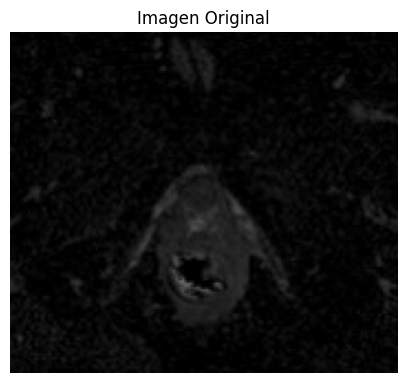

In [5]:
# Mostrar la primera imagen
def show_image(img, title="Imagen"):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


show_image(images[0], title="Imagen Original")

### Explanation

- Use `matplotlib` to display images** in grayscale.
- Remove the axes** (`plt.axis('off')`) for better display.


# Step 3: Image Normalization
## What do we want to do here?
We want to assign **luminosity values between 1 and 100** to each pixel.

In [6]:
def normalize_image(img):
    img = img.astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)

    if max_val == min_val:
        return np.ones_like(img) * 100

    normalized = 1 + (99 * (img - min_val) / (max_val - min_val))
    return normalized.astype(np.uint8)

- Convert the pixel values to a **range between 1 and 100**.
- Use the formula:
  \[
  \text{normalized_pixel} = 1 + 99 \times \frac{original_pixel_text} - \text{ minimum}}{ maximum} - \text{minimum}}
  \]
- **Why it is useful:**  
  - It allows us to treat all images at the same scale, regardless of their original lighting.

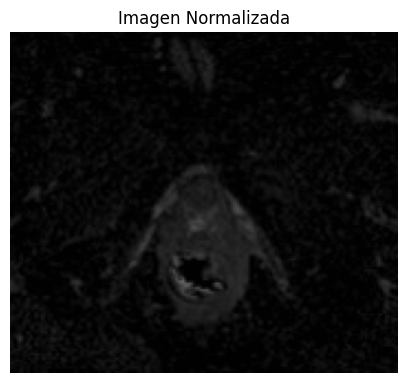

In [7]:
normalized_img = normalize_image(images[0])
show_image(normalized_img, title="Imagen Normalizada")

### Explanation
- The minimum (`min_val`) and maximum (`max_val`) brightness is calculated.
- Each pixel is normalized with the formula:
  \[
  \Â¨text{normalized pixel value} = 1 + 99 \times \frac{original pixel value} - \text{ minimum}}{ maximum} - \text{ minimum}}
  \]
- This allows us to standardize all images on the **1-100** scale.


# Step 4: Binarization with Different Thresholds
## What do we want to do here?
We want to convert the image to **black and white** according to a threshold.


In [8]:
def binarize_image(img, threshold):
    binary_img = np.where(img < threshold, 0, 255).astype(np.uint8)
    # ðŸ“Œ Asegurar que la imagen sea de 1 solo canal
    if len(binary_img.shape) > 2:
        binary_img = cv2.cvtColor(binary_img, cv2.COLOR_BGR2GRAY)
    return binary_img

- Converts the image to black and white** according to a threshold (`threshold`).
- Pixels with value **less than threshold** â†’ **Black (0)**.
- Pixels with value **greater than or equal to the threshold** â†’ **White (255)**.

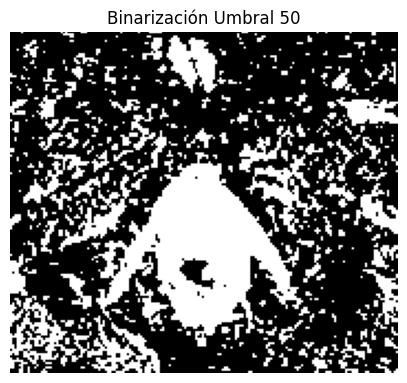

In [9]:
binary_img = binarize_image(normalized_img, 10)
show_image(binary_img, title="BinarizaciÃ³n Umbral 50")

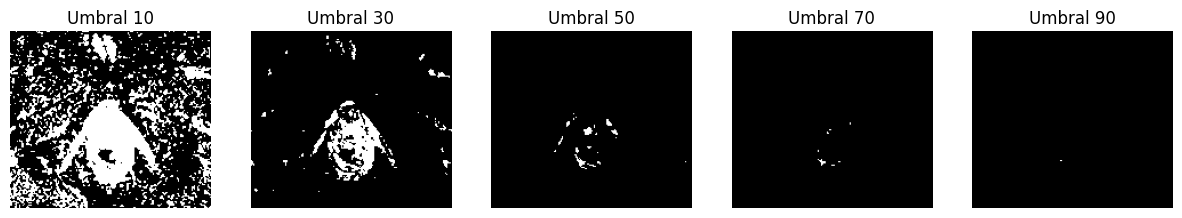

In [10]:
thresholds = [10, 30, 50, 70, 90]
fig, axes = plt.subplots(1, len(thresholds), figsize=(15, 5))

for i, t in enumerate(thresholds):
    binary_img = binarize_image(normalized_img, t)
    axes[i].imshow(binary_img, cmap='gray')
    axes[i].set_title(f'Umbral {t}')
    axes[i].axis('off')

plt.show()

### ExplicaciÃ³n
1. **Usamos `np.where(img < umbral, 0, 255)`**  
   - Si un pÃ­xel es menor que el umbral, se pone a **negro (0)**.
   - Si es mayor o igual, se pone a **blanco (255)**.
2. **Se aplican mÃºltiples umbrales (10, 30, 50, 50, 70, 90)** y se representan grÃ¡ficamente.



# Paso 5: Detectar componentes conectados
## Â¿QuÃ© queremos hacer aquÃ­?
Queremos contar cuÃ¡ntos **grupos de pÃ­xeles negros conectados** hay en la imagen.

In [11]:
def binarize_image(img, threshold):
    binary_img = np.where(img < threshold, 0, 255).astype(np.uint8)
    # ðŸ“Œ Asegurar que la imagen sea de 1 solo canal
    if len(binary_img.shape) > 2:
        binary_img = cv2.cvtColor(binary_img, cv2.COLOR_BGR2GRAY)
    return binary_img

In [12]:
def detect_components(binary_img):
    # ðŸ“Œ Asegurar que la imagen tiene solo 1 canal
    if len(binary_img.shape) > 2:
        binary_img = cv2.cvtColor(binary_img, cv2.COLOR_BGR2GRAY)
    # ðŸ“Œ Asegurar que los valores sean np.uint8 (0 y 255)
    binary_img = binary_img.astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary_img)
    return num_labels, labels

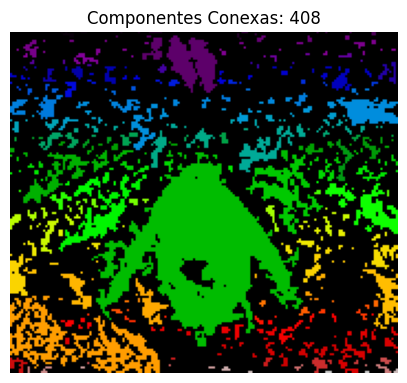

In [13]:
binary_img_50 = binarize_image(normalized_img, 10)
num_components, labeled_img = detect_components(binary_img_50)

plt.figure(figsize=(5, 5))
plt.imshow(labeled_img, cmap='nipy_spectral')
plt.title(f'Componentes Conexas: {num_components - 1}')
plt.axis('off')
plt.show()

- Find regions of connected black pixels.
- Use `cv2.connectedComponents()` to count how many pixel groups exist.

### Explanation
- **`cv2.connectedComponents()`** detects connected pixel regions.
- The image is displayed with colors to differentiate the regions.


# Step 6: Generate Beta Curves
## What do we want to do here?
We want to visualize how **the number of components and loops** changes as the threshold is varied.

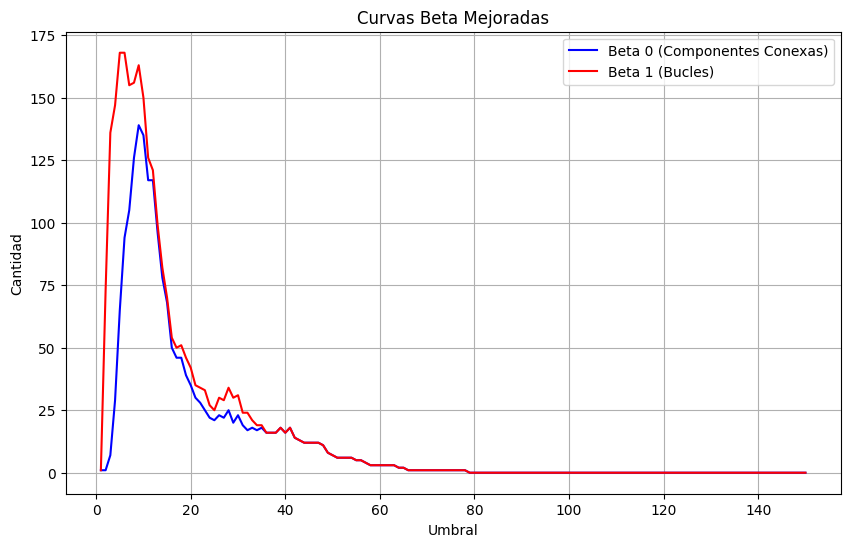

In [18]:
beta_0 = []
beta_1 = []
threshold_range = range(1, 151)  # Extiende el rango del umbral para mÃ¡s datos

for t in threshold_range:
    # Aplicar un filtro de suavizado para reducir ruido antes de la binarizaciÃ³n
    smoothed_img = cv2.GaussianBlur(normalized_img, (5, 5), 0)
    binary_img = binarize_image(smoothed_img, t)

    # Detectar componentes conexas
    num_components, _ = detect_components(binary_img)

    # Detectar contornos internos y externos usando cv2.RETR_TREE
    contours, _ = cv2.findContours(
        binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    num_loops = len(contours)

    beta_0.append(num_components - 1)  # Cantidad de componentes conexas
    beta_1.append(num_loops)           # Cantidad de bucles (contornos)

# Graficar las curvas Beta
plt.figure(figsize=(10, 6))
plt.plot(threshold_range, beta_0,
         label="Beta 0 (Componentes Conexas)", color='b')
plt.plot(threshold_range, beta_1, label="Beta 1 (Bucles)", color='r')
plt.xlabel("Umbral")
plt.ylabel("Cantidad")
plt.legend()
plt.title("Curvas Beta Mejoradas")
plt.grid(True)
plt.show()

### Explanation
- Beta 0`** = Connected components (groups of connected pixels).
- **`Beta 1`** = Loops (white pixels completely surrounded by black).
- How **these values** change with threshold is plotted.


# Conclusion
With this analysis, we have achieved:
âœ… Extract topological information from images.  
âœ… Visualize the evolution of structures as a function of threshold.  
âœ… Generate **beta curves** and **persistence diagrams**.  

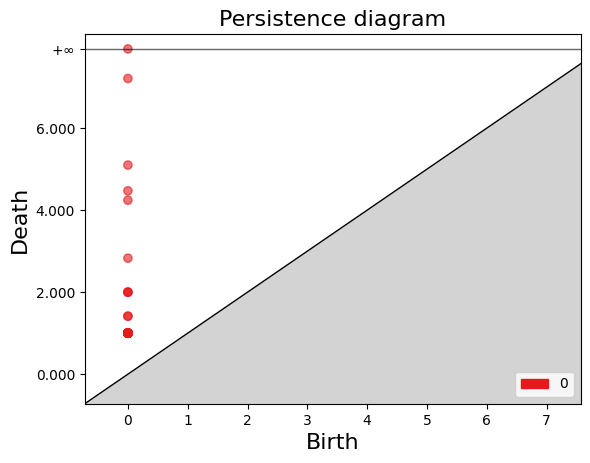

In [17]:
def downscale_image(img, scale_factor=0.1):
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

# ðŸ“Œ FunciÃ³n para calcular la persistencia


def compute_persistence(binary_img):
    # ReducciÃ³n de tamaÃ±o antes de calcular la persistencia
    # Reducir la imagen a un 10% de su tamaÃ±o original
    reduced_img = downscale_image(binary_img, scale_factor=0.1)

    # ðŸ“Œ Obtener las posiciones de los puntos 0 en la imagen binaria
    points = np.argwhere(reduced_img == 0)

    # ðŸ“Œ Crear el complejo de Rips con puntos reducidos
    rips_complex = gd.RipsComplex(points=points)

    # ðŸ“Œ Crear el Ã¡rbol de simplices con dimensiÃ³n mÃ¡xima 1
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    persistence = simplex_tree.persistence()

    # ðŸ“Œ Mostrar el diagrama de persistencia
    gd.plot_persistence_diagram(persistence)
    

compute_persistence(binary_img_50)

- Uses **algebraic topology** to analyze how black regions appear and disappear as the threshold changes.
- **Representation in graphs**:
  - **X-axis** â†’ Time at which a feature is born.
  - **Y-axis** â†’ Time at which it disappears.